# Sequential Model-based Algorithm Configuration (SMAC)

[SMAC Paper](https://www.cs.ubc.ca/~hutter/papers/10-TR-SMAC.pd)

### Algo's basics
1) generate a X number of random samples
2) build an Random Forest Regressor (RF) on those samples
3) generate Y number of candidates and check there expected performance on the RF 
4) run the reconstruction algo on the best candidate
5) evaluate candidate and update RF
6) repeat

This algorithm seems great to me for reconstruction algorithms that take a long time to run since we can use an RF mdoel to quickly estimate the performance of a certain candidate.
When the RF gets more datapoints it prediction becomes better and _should_ converge

Think this would be suitable for `Graph_DFS` since this takes ~30 sec to run on my Mac.

Finnaly for these larger models we should have a high `numberOfCandidates` while minimising `numberOfContextDataPoints`


In [1]:
import os, sys, json 
import numpy as np 
sys.path.append(os.path.abspath(".."))

from velopix_wrappers.parameter_optimisers import optimiserBase
from velopix_wrappers.velopix_pipeline import TrackFollowingPipeline

In [2]:
from copy import deepcopy # I recommend using deepcopy the prevent weird shared objects from occuring (love python <3)
import random
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import norm

class SMAC(optimiserBase):
    def __init__(self, numberOfContextDataPoints: int, MinimalNumberOfRuns: int, numberOfCandidates: int, objectiveWeights: list[float], randomForestEstimators: int) -> None:
        super().__init__(Objective="min")
        """
        history structure I'll use here:
        Results : {
            parameters: {...},
            score: float
        }
        """
        self.history = {} 
        self.w = objectiveWeights
        self.score_history = []
        self.patience = MinimalNumberOfRuns
        self.convergence_tolerance = 1e-4
        self.context_iterations = numberOfContextDataPoints
        self.RFestimators = randomForestEstimators
        self.n_candidates = numberOfCandidates

    # This init method randomly initialises the parameteres and could be used in other implementations
    def init(self) -> dict:
        self.iteration = 0
        self.prev_config = self.__random_sample()
        return deepcopy(self.prev_config)

    def next(self) -> dict:
        self.__evaluate_run()

        self.iteration += 1

        # SMAC uses random configurations initialy to build a RF model
        if self.iteration <= self.context_iterations:
            self.prev_config = self.__random_sample()
            return deepcopy(self.prev_config)
        
        # Build the RF using the context gained
        X = np.array([self.__to_vec(c) for c in self.history])
        y = np.array([s for s in self.history.values()])

        # NOTE this is fairly expensive, retraining a RF everytime we update the model
        RF = RandomForestRegressor(n_estimators=self.RFestimators)
        RF.fit(X, y)

        # here the actual update func starts
        best_ei = -float("inf")
        best_candidate = None
        for _ in range(self.n_candidates):
            candidate = self.__random_sample()
            x_vec = np.array(self.__to_vec(candidate)).reshape(1, -1)
            preds = np.array([est.predict(x_vec)[0] for est in RF.estimators_])
            mu = np.mean(preds)
            sigma = np.std(preds)
            # here calculate expected improvement
            if sigma > 0:
                z = (self.best_score - mu) / sigma
                expectedImprov = (self.best_score - mu) * norm.cdf(z) + sigma * norm.pdf(z)
            else:
                expectedImprov = 0.0
            if expectedImprov > best_ei:
                best_ei = expectedImprov
                best_candidate = candidate

        # if no candidate is selected return random config
        if best_candidate is None:
            best_candidate = self.__random_sample()

        self.prev_config = best_candidate
        return deepcopy(self.prev_config)


    def is_finished(self):
        if len(self.score_history) > self.patience:
            recent_scores = self.score_history[-self.patience:]
            improvement = max(recent_scores) - min(recent_scores)
            if improvement < self.convergence_tolerance:
                return True
        return False
    
    def objective_func(self):
        results = self.get_run_data()

        n_tracks = results.get("total_tracks")
        if n_tracks <= 0: return float("-inf") * self.__objective_factor

        runtime = results.get("inference_time") 
        ghost_rate = results.get("overall_ghost_rate")
        clones = results.get("categories", []) 
        clone_pct = sum(map(lambda clone: clone.get("clone_percentage", 0), clones))

        score = self.w[0] * ghost_rate +  self.w[1] *clone_pct / len(clones) + self.w[2] * runtime / 3
        if score is None:
            raise("Score cannot be None")
        return score
    """ 
    Internal Helper Classes 
    """

    def __random_sample(self) -> dict:
        schema = self._algorithm.get_config() # Get the algorithm parameters schema
        config = {}

        for key, (type, _) in schema.items(): # Iterate over the parameters and intialise randomly them according to there type
            if type == bool:
                config[key] = random.choice([True, False])
            elif type in (float, int):
                low, high = self._algorithm._bounds().get(key)
                config[key] = type(random.uniform(low, high))
        return config
    
    def __evaluate_run(self) -> None:
        score = self.objective_func()
        if score == None: print("Score is null")
        self.score_history.append(score)
        self.history[tuple(self.prev_config.items())] = deepcopy(score)
        compare = score < self.best_score if self.objective == "min" else score > self.best_score
        if compare:
            self.best_score = score
            self.best_config = deepcopy(self.prev_config)

    def __to_vec(self, config: dict) -> list:
        vec = []
        if isinstance(config, tuple):
            config = dict(config)
        for key in list(self._algorithm.get_config().keys()):
            value = config[key]
            if isinstance(value, bool):
                vec.append(1.0 if value else 0.0)
            else:
                vec.append(float(value))
        return vec


### Load Event Data

In [3]:
events = []
n_files = 100

for i in range(0, n_files):
    if i == 51:
        """
        There's an issue with event 51 -> module_prefix_sum contains value 79 twice resulting in and indexing error when loading the event
        """
        print(f"Skipping problematic file: velo_event_{i}.json")
    else:
        event_file = open(os.path.join("../DB/raw", f"velo_event_{i}.json"))
        json_data = json.loads(event_file.read())
        events.append(json_data)
        event_file.close()

Skipping problematic file: velo_event_51.json


In [4]:
Optimiser = SMAC(
    numberOfContextDataPoints=25, 
    MinimalNumberOfRuns=60, 
    numberOfCandidates = 5,
    objectiveWeights = [5, 1, 0.2],
    randomForestEstimators=15 # For each parameter 3
)

In [5]:
optimalParameters = TrackFollowingPipeline(events=events, intra_node=False).optimise_parameters(Optimiser, max_runs=1625)

Optimising: 100%|██████████| 1625/1625 [29:55<00:00,  1.10s/it]


In [6]:
print(f"Best set of parameters found: {optimalParameters} \nWith score: {Optimiser.best_score}")

Best set of parameters found: {'x_slope': 0.29913226790613623, 'y_slope': 0.3613913961223628, 'x_tol': 0.4063266062339379, 'y_tol': 0.4215274392291801, 'scatter': 0.1812838714061961} 
With score: 46.76654823129788


In [7]:
TF = TrackFollowingPipeline(events=events, intra_node=False)
TF.print_validation(optimalParameters, verbose=False)

30227 tracks including 2541 ghosts (8.4%). Event average ghost rate: 7.4%
velo                  24025 from  28026 ( 85.7%,  85.7%)  661 clones ( 2.75%), purity: ( 97.54%,  97.87%), hitEff: ( 95.16%,  94.46%)
long                   7816 from   8076 ( 96.8%,  96.8%)  349 clones ( 4.47%), purity: ( 97.64%,  98.82%), hitEff: ( 96.79%,  93.71%)
long>5GeV              4992 from   5100 ( 97.9%,  97.9%)  237 clones ( 4.75%), purity: ( 97.50%,  98.68%), hitEff: ( 95.90%,  93.55%)
long_strange            367 from    385 ( 95.3%,  95.3%)   16 clones ( 4.36%), purity: ( 97.07%,  98.21%), hitEff: (100.00%,  93.79%)
long_strange>5GeV       168 from    174 ( 96.6%,  96.6%)    9 clones ( 5.36%), purity: ( 97.33%,  95.83%), hitEff: (100.00%,  93.72%)
long_fromb              423 from    444 ( 95.3%,  95.3%)   22 clones ( 5.20%), purity: ( 95.95%, 100.00%), hitEff: (100.00%,  92.19%)
long_fromb>5GeV         331 from    343 ( 96.5%,  96.5%)   20 clones ( 6.04%), purity: ( 95.46%, 100.00%), hitEff: (100.00

## Lets visualise the performance over the runs

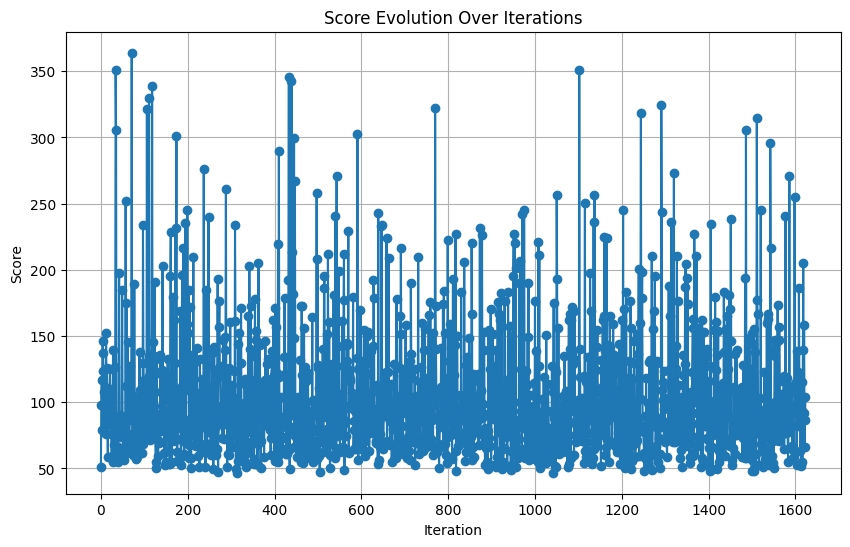

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(Optimiser.score_history, marker='o', linestyle='-')
plt.title("Score Evolution Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.grid(True)
plt.show()


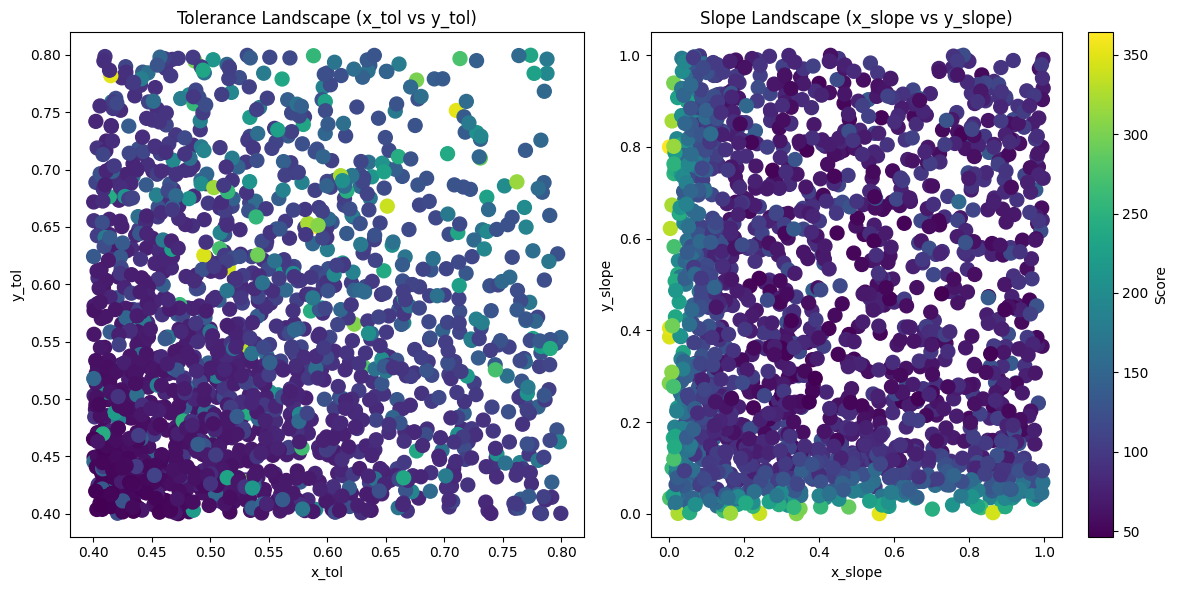

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
data = []
for key, score in Optimiser.history.items():
    param_dict = dict(key)
    data.append({
        'x_slope': param_dict['x_slope'],
        'y_slope': param_dict['y_slope'],
        'x_tol': param_dict['x_tol'],
        'y_tol': param_dict['y_tol'],
        'score': score
    })
df = pd.DataFrame(data)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sc0 = axs[0].scatter(df['x_tol'], df['y_tol'], c=df['score'], cmap='viridis', s=100)
axs[0].set_xlabel('x_tol')
axs[0].set_ylabel('y_tol')
axs[0].set_title("Tolerance Landscape (x_tol vs y_tol)")
sc1 = axs[1].scatter(df['x_slope'], df['y_slope'], c=df['score'], cmap='viridis', s=100)
axs[1].set_xlabel('x_slope')
axs[1].set_ylabel('y_slope')
axs[1].set_title("Slope Landscape (x_slope vs y_slope)")
cbar = fig.colorbar(sc0, ax=axs[1], label='Score')
plt.tight_layout()
plt.show()


## Lets try to implement this using Multi-Objective Optimalisation

In [22]:
class MultiObjectiveSMAC(optimiserBase):
    def __init__(self, numberOfContextDataPoints: int, MinimalNumberOfRuns: int, numberOfCandidates: int, objectiveWeights: list[float], randomForestEstimators: int) -> None:
        super().__init__(Objective="min")
        """
        History structure:
          - self.history: dictionary mapping configuration keys to scalar scores.
          - self.pareto_front: list of tuples (config, objective_vector) representing non-dominated solutions.
        """
        self.history = {} 
        self.pareto_front = []
        self.score_history = []
        self.patience = MinimalNumberOfRuns
        self.convergence_tolerance = 1e-4
        self.context_iterations = numberOfContextDataPoints
        self.RFestimators = randomForestEstimators
        self.n_candidates = numberOfCandidates
        self.w = objectiveWeights
        self.best_score = float("inf")
        self.best_config = None
        self.iteration = 0

    def init(self) -> dict:
        self.iteration = 0
        self.prev_config = self.__random_sample()
        return deepcopy(self.prev_config)

    def next(self) -> dict:
        self.__evaluate_run()
        self.iteration += 1

        # Use random configurations for the first context iterations to gather data.
        if self.iteration <= self.context_iterations:
            self.prev_config = self.__random_sample()
            return deepcopy(self.prev_config)
        
        # Build the Random Forest using the gathered data.
        X = np.array([self.__to_vec(dict(cfg)) for cfg in self.history.keys()])
        y = np.array([s for s in self.history.values()])

        RF = RandomForestRegressor(n_estimators=self.RFestimators)
        RF.fit(X, y)

        best_ei = -float("inf")
        best_candidate = None
        for _ in range(self.n_candidates):
            candidate = self.__random_sample()
            x_vec = np.array(self.__to_vec(candidate)).reshape(1, -1)
            preds = np.array([est.predict(x_vec)[0] for est in RF.estimators_])
            mu = np.mean(preds)
            sigma = np.std(preds)
            # Compute Expected Improvement (EI)
            if sigma > 1e-8:
                z = (self.best_score - mu) / sigma
                expectedImprov = (self.best_score - mu) * norm.cdf(z) + sigma * norm.pdf(z)
            else:
                expectedImprov = 0.0
            if expectedImprov > best_ei:
                best_ei = expectedImprov
                best_candidate = candidate

        if best_candidate is None:
            best_candidate = self.__random_sample()

        self.prev_config = best_candidate
        return deepcopy(self.prev_config)

    def is_finished(self):
        if len(self.score_history) > self.patience:
            recent_scores = self.score_history[-self.patience:]
            improvement = max(recent_scores) - min(recent_scores)
            if improvement < self.convergence_tolerance:
                return True
        return False
    
    def objective_func(self):
        results = self.get_run_data()
        n_tracks = results.get("total_tracks")
        if n_tracks <= 0: 
            return float("-inf") * self.__objective_factor

        runtime = results.get("inference_time") 
        ghost_rate = results.get("overall_ghost_rate")
        clones = results.get("categories", [])
        if clones:
            clone_pct = sum(map(lambda clone: clone.get("clone_percentage", 0), clones)) / len(clones)
        else:
            clone_pct = 0

        # Scalarized objective: lower is better.
        score = self.w[0] * ghost_rate + self.w[1] * clone_pct + self.w[2] * (runtime / 3)
        if score is None:
            raise Exception("Score cannot be None")
        return score

    """ 
    Internal Helper Functions
    """

    def __random_sample(self) -> dict:
        schema = self._algorithm.get_config()  # Get the algorithm's parameter schema.
        config = {}
        for key, (param_type, _) in schema.items():
            if param_type == bool:
                config[key] = random.choice([True, False])
            elif param_type in (float, int):
                low, high = self._algorithm._bounds().get(key)
                config[key] = param_type(random.uniform(low, high))
        return config
    
    def __evaluate_run(self) -> None:
        # Compute the multi-objective vector for the current run.
        obj_vector = self.__objective_vector()
        # Update the Pareto front with the current configuration.
        self.__update_pareto_front(self.prev_config, obj_vector)
        score = self.objective_func()
        if score is None:
            print("Score is null")
        self.score_history.append(score)
        self.history[tuple(sorted(self.prev_config.items()))] = deepcopy(score)
        compare = score < self.best_score if self.objective == "min" else score > self.best_score
        if compare:
            self.best_score = score
            self.best_config = deepcopy(self.prev_config)

    def __to_vec(self, config: dict) -> list:
        vec = []
        for key in list(self._algorithm.get_config().keys()):
            value = config[key]
            if isinstance(value, bool):
                vec.append(1.0 if value else 0.0)
            else:
                vec.append(float(value))
        return vec
    
    def __objective_vector(self) -> tuple:
        results = self.get_run_data()
        n_tracks = results.get("total_tracks")
        if n_tracks <= 0: 
            return (float("inf"), float("inf"), float("inf"))
        runtime = results.get("inference_time") 
        ghost_rate = results.get("overall_ghost_rate")
        clones = results.get("categories", [])
        if clones:
            clone_pct = sum(clone.get("clone_percentage", 0) for clone in clones) / len(clones)
        else:
            clone_pct = 0
        # Return a tuple (ghost_rate, clone_pct, runtime) assuming all objectives are to be minimized.
        return (ghost_rate, clone_pct, runtime)
    
    def __update_pareto_front(self, config, obj_vector: tuple) -> None:
        # Remove any solutions in the Pareto front that are dominated by the new configuration.
        self.pareto_front = [(cfg, vec) for (cfg, vec) in self.pareto_front if not self.__dominates(obj_vector, vec)]
        # Add the new configuration if it is not dominated by any current solution.
        if not any(self.__dominates(vec, obj_vector) for (_, vec) in self.pareto_front):
            self.pareto_front.append((config, obj_vector))
    
    def __dominates(self, obj1, obj2) -> bool:
        """
        For minimization: returns True if obj1 dominates obj2 (i.e., all values of obj1 are less than or equal
        to those in obj2, and at least one is strictly less).
        """
        return all(o1 <= o2 for o1, o2 in zip(obj1, obj2)) and any(o1 < o2 for o1, o2 in zip(obj1, obj2))


In [23]:
MultiObjectiveOptimiser = MultiObjectiveSMAC(
    numberOfContextDataPoints=25, 
    MinimalNumberOfRuns=60, 
    numberOfCandidates = 5,
    objectiveWeights = [5, 1, 0.2],
    randomForestEstimators=15 # For each parameter 3
)

In [24]:
optimalParameters = TrackFollowingPipeline(events=events, intra_node=False).optimise_parameters(MultiObjectiveOptimiser, max_runs=250)

Optimising: 100%|██████████| 250/250 [04:14<00:00,  1.02s/it]


In [25]:
print(f"Best set of parameters found: {optimalParameters} \nWith score: {Optimiser.best_score}")

Best set of parameters found: {'x_slope': 0.39697313481163676, 'y_slope': 0.42756665169990005, 'x_tol': 0.45124502651541065, 'y_tol': 0.4264853810986236, 'scatter': 0.1445557131204284} 
With score: 46.76654823129788


In [26]:
TF = TrackFollowingPipeline(events=events, intra_node=False)
TF.print_validation(optimalParameters, verbose=False)

31510 tracks including 2957 ghosts (9.4%). Event average ghost rate: 8.3%
velo                  24867 from  28026 ( 88.7%,  88.7%)  690 clones ( 2.77%), purity: ( 97.37%,  97.75%), hitEff: ( 95.47%,  94.34%)
long                   7867 from   8076 ( 97.4%,  97.4%)  360 clones ( 4.58%), purity: ( 97.45%,  98.82%), hitEff: ( 97.71%,  93.43%)
long>5GeV              4983 from   5100 ( 97.7%,  97.7%)  242 clones ( 4.86%), purity: ( 97.32%,  98.67%), hitEff: ( 97.25%,  93.24%)
long_strange            365 from    385 ( 94.8%,  94.8%)   18 clones ( 4.93%), purity: ( 96.93%,  98.21%), hitEff: (100.00%,  93.48%)
long_strange>5GeV       167 from    174 ( 96.0%,  96.0%)   10 clones ( 5.99%), purity: ( 97.16%,  95.83%), hitEff: (100.00%,  93.20%)
long_fromb              425 from    444 ( 95.7%,  95.7%)   21 clones ( 4.94%), purity: ( 95.85%, 100.00%), hitEff: (100.00%,  92.57%)
long_fromb>5GeV         331 from    343 ( 96.5%,  96.5%)   21 clones ( 6.34%), purity: ( 95.34%, 100.00%), hitEff: (100.00

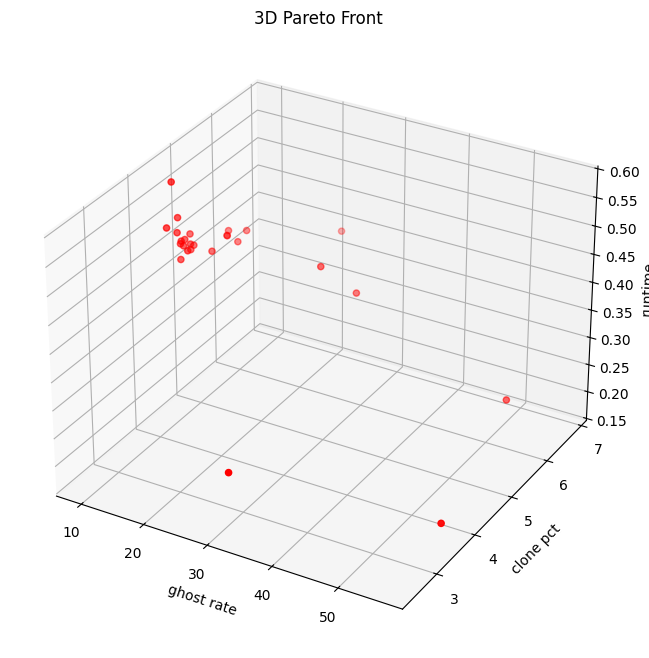

In [28]:
from mpl_toolkits.mplot3d import Axes3D

def plot_pareto_front_3d(pareto_front):
    """
    Plots a 3D scatter plot of the Pareto front for three objectives.

    Parameters:
    - pareto_front: List of tuples (config, (obj1, obj2, obj3))
    """
    x_vals = [vec[0] for (_, vec) in pareto_front]
    y_vals = [vec[1] for (_, vec) in pareto_front]
    z_vals = [vec[2] for (_, vec) in pareto_front]
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_vals, y_vals, z_vals, c='red', marker='o')
    ax.set_xlabel("ghost rate")
    ax.set_ylabel("clone pct")
    ax.set_zlabel("runtime")
    ax.set_title("3D Pareto Front")
    plt.show()

plot_pareto_front_3d(MultiObjectiveOptimiser.pareto_front)